# BAYESIAN NEURAL NETWORK (BNN) BASICS

# Setup
## Library for PyTorch implementation of BNNs
The implementation of BNNs in Python using PyTorch can be done using [`torchbnn`](https://github.com/Harry24k/bayesian-neural-network-pytorch), which can be installed as follows:

```
!pip install torchbnn
```

## Necessary imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

# BNN regression

> **References**:
>
> - [Bayesian Neural Network Regression Demo](https://github.com/Harry24k/bayesian-neural-network-pytorch/blob/master/demos/Bayesian%20Neural%20Network%20Regression.ipynb)
> - [From Theory to Practice with Bayesian Neural Network, Using Python](https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825)

## Creating a synthetic regression problem
Regression will be done on this synthetic data. We generate the data using:

$y_i = f(x_i) + \epsilon_i$

- $y_i$ is the dependent variable (the "output" or "target")
- $x_i$ is the independent variable (the "input" or "feature" or "predictor")
- $\epsilon_i$ is the random noise given to the $i$-th data point

**NOTE**: _This regression problem considers only one independent variable._

The goal of regression is to estimate $f$ given the dataset $D = (x, y) = \{(x_1, y_1), (x_2, y_2) ... (x_n, y_n)\}$.

---

Specifically, we shall define:

- $f(x_i) = x_i^3 - x_i^2$
- $\epsilon_i \sim \text{Uniform}(-3, 3)$
- $n = 500$

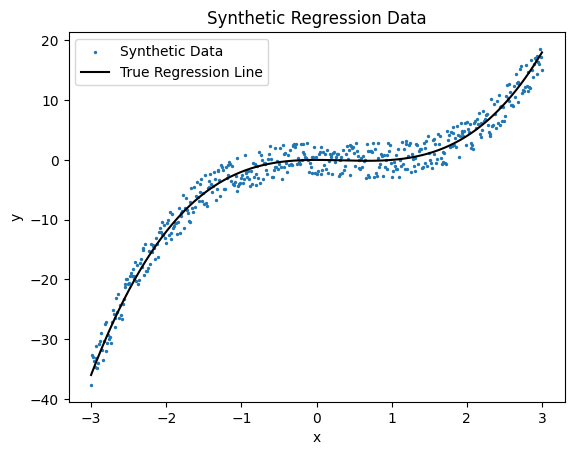

In [2]:
# SYNTHETIC DATA GENERATION

# Defining the inputs x = (x_1, x_2 ... x_500):
x = torch.linspace(-3, 3, 500)

# Defining f(x):
f = lambda x: x**3 - x**2

# Defining random noise ɛ = (ɛ_1, ɛ_2 ... ɛ_500):
ɛ = lambda n: 6*torch.rand(n) - 3
# NOTE 1: `torch.rand` draws from a uniform distribution on the interval [0, 1]
# NOTE 2: 6 is effectively the size of the range noise values
# NOTE 3: The above uniform distribution is on the interval [-3, 3]
# NOTE 4: I defined noise as a function so we can reuse it during testing
# NOTE 5: I defined the noise function in terms of 'n' to clarify that it is not dependent on `x`

# Adding the above to generate the final target value:
y = f(x) + ɛ(500)

#================================================
# DATA CONVERSION INTO TENSORS

# Converting each array into a 1D column tensor:
# NOTE: This is done easen passing the data through the neural network
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

#================================================
# DATA PRESENTATION

plt.scatter(x.data.numpy(), y.data.numpy(), s=2, label='Synthetic Data')
plt.plot(x.data.numpy(), f(x.data.numpy()), color='k', label='True Regression Line')
plt.title('Synthetic Regression Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Defining the neural network
For our simple BNN, we shall use Bayesian linear layers. A Bayesian linear layer is a linear layer with two key differences from a regular linear layer: (1) its weights are automatically initialised using a certain normal distribution with a certain standard deviation, and (2) its forward function is defined such that for each forward function call, the weights change probabilistically based on the aforementioned normal distribution. This normal distribution represents the prior of the linear layer (i.e. the assumed distribution of the layer's parameters before any data is observed): It is implemented by the class `BayesLinear` in `torch.bnn`, and the arguments of its constructor are as follows:

- `prior_mu` (float): Mean of prior normal distribution
- `prior_sigma` (float): Standard deviation of prior normal distribution
- Other arguments are following [linear of pytorch 1.2.0](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py)

In particular, for each function call, the weights $w$ are changed to $w_\mu + \text{Normal}(0, \sigma)$, where $w_\mu$ is the mean of the layer's current weights and $\sigma$ is the standard deviation of the prior normal distribution. The bias term is changed the same way. Hence, a BNNs predictions are not deterministic, like a regular neural network, but probabilistic; each prediction of the model is going to be slightly different, as though the model parameters are not fixed but drawn from the estimated posterior distribution.

_Additional points_...

- `BayesLinear` offers a `freeze` function that can freeze the weights
- Freezing the Bayesian linear layer's weights makes it behave like a regular linear layer
- Its `unfreeze` _function unfreezes the weights again

> **Reference**: [torchbnn/modules/linear.py](https://github.com/Harry24k/bayesian-neural-network-pytorch/blob/master/torchbnn/modules/linear.py)

---

The loss is the weighted sum of the mean squared error (MSE) and the Kullback-Leibler divergence (KL divergence). The KL divergence is implemented by the class `BKLLoss` in `torch.bnn` ('B' stands for "Bayesian", since we are calculating the KL divergence for a Bayesian layer). Its constructor has no mandatory arguments and some optional arguments, which are as follows:

- `reduction`: Specifies the reduction to apply to the output (default = 'mean')
    - 'mean' $\implies$ The sum of the output will be divided by the number elements of the output
    - 'sum' $\implies$ the output will be summed- `last_layer_only` (boolean): `True` means only the last layer's KL divergence is returned (default = `False`).

> **Reference**: [torchbnn/modules/loss.py](https://github.com/Harry24k/bayesian-neural-network-pytorch/blob/master/torchbnn/modules/loss.py)

In [3]:
# DEFINING THE MODEL

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=1, out_features=100), # Input layer
    nn.ReLU(),                                                                   # Non-linear activation
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=1)) # Output layer

#================================================
# DEFINING THE LOSS FUNCTION

# Initialising MSE part of the loss function:
mse_loss = nn.MSELoss()

# Initialising the KL divergence part of the loss function:
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01 # The weight given to the KL divergence part of the loss function

# Initialising the optimiser used for gradient descent:
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Training the model
One regression step and hence one training step involves:

1. Calculating the predicted values for all the inputs
2. Calculating the total loss for all the predicted values
3. Altering the weights through backpropagation

---

Also note the following:

- $x$ is the tensor of all inputs
- $y$ is the tensor of all "actual" outputs ("actual" in quotes because our data is synthetic)
- $f$ is the target function, such that $f(x) \approx y$
- We shall perform a high number of regression steps to estimate the target function $f$

In [4]:
for step in range(3000):
    # Obtaining the model's predicted values for the inputs:
    prediction = model(x)

    # Calculating the loss function:
    mse = mse_loss(prediction, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl

    # Optimisation step:
    optimizer.zero_grad() # Resetting the optimiser's gradients
    cost.backward()       # Calculating the gradients for backpropagation
    optimizer.step()      # Applying the gradients for backpropagation
    
print('MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

MSE : 5.07, KL : 0.87


## Testing the model

Generating the synthetic test data...

In [5]:
x_test = torch.linspace(-3, 3, 500)
y_test = f(x_test) + ɛ(500)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

Obtaining and testing the predictions...

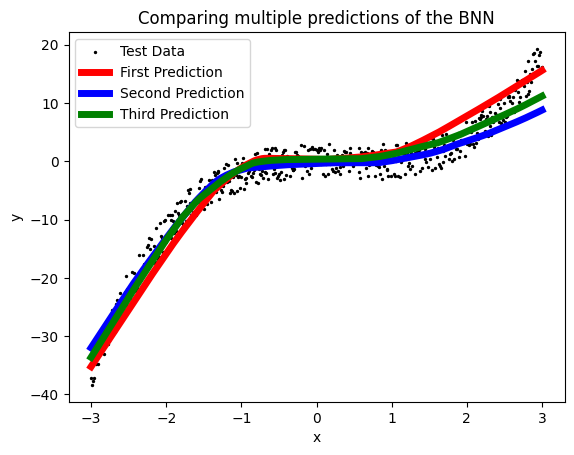

In [6]:
# Plotting the test data:
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), color='k', s=2, label='Test Data') 

# Obtaining and plotting multiple predictions:
y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'r-', linewidth=5, label='First Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'b-', linewidth=5, label='Second Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'g-', linewidth=5, label='Third Prediction')

# Final formatting for the plot:
plt.title('Comparing multiple predictions of the BNN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Key points

We have seen how a BNN is a machine learning model that incorporates the power of a neural network while making the uncertainty about its parameters more explicit (by making the model's weights probabilistic). The idea is not to optimise the loss of a neural network but the loss of an unlimited class of neural networks; note that this unlimited class of neural networks is defined as the set of all neural networks whose parameters are distributed according to a particular probability distribution (initially assumed to be the prior distribution, later estimated to be the posterior distribution or at least close to it). In other words, we are optimising the probability distribution of our model parameters given a dataset. We optimise using a loss function that incorporates the metric known as Kullback-Leibler divergence (KL divergence), which is a way to quantify the distance between two distributions (in our case, we aim to quantify the estimated distance between the distribution of the model's parameters as defined by us and the actual posterior distribution of the model's parameters; we do not know the actual posterior distribution, which is why we esimate, as is explained in the next section). After optimising our loss function, we are able to use a model that is probabilistic. This means that if we repeat this model twice we get two different results, and if we repeat it many times, say, 10000 times, we can extract a robust statistical distribution of our results.

> **Reference**: [From Theory to Practice with Bayesian Neural Network, Using Python](https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825)

## Conceptual observations
Note that the theoretical approach we used is such that we try to minimise the distance between the distribution of our model's parameters and the actual posterior distribution of the model's parameters, so that when we sample parameter values from our distribution, we are approximately sampling from the actual posterior distribution. This theoretical approach is called **variational inference**, where our estimated distribution is called the variational distribution. It is key to note that we obviously do not know the posterior distribution; if we did, there would be no need to estimate it. Rather, to minimise the distance between the variational and posterior distributions, we use the evidence lower bound (ELBO), which is a formula derived from the actual KL divergence between the variational and posterior distributions:

$\displaystyle \text{ELBO} = \int_{\theta \in \Theta} q_\phi(\theta) \log \frac{p(\theta, D)}{q_\phi(\theta)} d\theta$

> **Read further**: ["Variational inference" from _Sampling Methods_ from **Bayesian Inference** from `conceptual-notes`](https://github.com/pranigopu/mastersProject/blob/main/conceptual-notes/bayesian-inference/sampling-methods/variational-inference-vi)